In [123]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplleaflet
import geopandas as geopd
import srtm
import gpxpy
import networkx as nx

In [2]:
# try and load file
gdf = geopd.read_file('./data/Boulder_Area_Trails.geojson') # 'Trails.geojson')
print("Trails: ", gdf.columns)

gdf_small = geopd.read_file('./data/Trails.geojson')
#print("Trails Dissolved: ", gdf.columns)


Trails:  Index(['OBJECTID', 'TRAILNAME', 'ALIAS', 'LENGTH', 'PEDESTRIAN', 'BIKE',
       'HORSE', 'OHV', 'TRAILTYPE', 'SURTYPE', 'STEWARD', 'DATAOWNER',
       'COMMENTS', 'SHAPESTLength', 'DOGS', 'GlobalID', 'BATTrailID',
       'geometry'],
      dtype='object')


In [3]:
for k in gdf.columns:
    print(k, gdf[k][0])

OBJECTID 1
TRAILNAME AHC Trail
ALIAS 
LENGTH 0.5
PEDESTRIAN Yes
BIKE No
HORSE No
OHV No
TRAILTYPE Trail
SURTYPE SoftSurface
STEWARD https://www.bouldercounty.org/open-space/education/museums/agricultural-heritage-center/
DATAOWNER Boulder County Parks and Open Space
COMMENTS dissolved
SHAPESTLength 849.2965328251734
DOGS No
GlobalID {EAC748F1-D30F-4E24-9710-B5C8000BA82A}
BATTrailID BCPOS-1
geometry MULTILINESTRING ((-105.1595259327879 40.20245056543753, -105.1595605107399 40.20238861700264, -105.1595950904884 40.20232666851115, -105.1596177154571 40.20228013403499, -105.1596403395276 40.20223359952695, -105.1596310383711 40.20217470818947, -105.1596217363164 40.20211581611479, -105.1596221297785 40.20203733077622, -105.1596225223422 40.2019588453468, -105.1596356602033 40.20189020894369), (-105.1595259327879 40.20245056543753, -105.1595693214162 40.20249240684255, -105.1595709428752 40.20254771918638, -105.1595565446779 40.20260788360747, -105.1595384993205 40.20266659824025, -105.1595

In [4]:
trail_names_full = gdf.TRAILNAME

In [5]:
trail_names_short = gdf_small.FEATURE_NAME

In [6]:
for k in trail_names_full:
    if not k is None:
        if 'Mud' in k or 'mud' in k:
            print(k)

Mud Lake Connector Trail
Mud Lake Access Trail
Mud Lake Access Trail
Nederland Elem. to Mud Lake
Mud Lake to Hwy. 72


In [7]:
gdf.loc[gdf.TRAILNAME=='Mud Lake Connector Trail']

,OBJECTID,TRAILNAME,ALIAS,LENGTH,PEDESTRIAN,BIKE,HORSE,OHV,TRAILTYPE,SURTYPE,STEWARD,DATAOWNER,COMMENTS,SHAPESTLength,DOGS,GlobalID,BATTrailID,geometry
90,91,Mud Lake Connector Trail,None,0.064478,Yes,Yes,Yes,No,Trail,SoftSurface,https://www.bouldercounty.org/open-space/parks...,Boulder County Parks and Open Space,segmented,135.380251,Yes,{1C256E4A-6B85-4221-8C16-9C584F5B5C8E},BCPOS-95,"LINESTRING (-105.51363 39.97616, -105.51352 39..."


In [8]:
gdf_small.loc[0]

OBJECTID                                                   499057
FEATURE_TYPE                                                    3
LOCATION                                                 Mud Lake
FEATURE_NAME                             Mud Lake Connector Trail
SURFACE_TYPE                                              Natural
WIDTH                                                           3
SOURCE                                                        gps
SRC_YEAR                                                     2004
STATUS                                                   existing
OWNER                                                      County
MAINTENANCE                                                County
ENFORCEMENT                                                County
PED                                                           Yes
BIKE                                                          Yes
HORSE                                                         Yes
DOG       

The key columns here are:

    1) SLength = trail length in feet
    
    2) VerticalGain = gain in feet (*need to update with elevation data for consistency*)
    
    3) Z_Min, Z_Max, Z_Mean = min, max, average altitude *see above*
    
    4) Min_Slope, Max_Slope, Avg_Slope = percent grade *see above*
    
    5) geometry = list of coordinates (as LINESTRING object)... 
                  use LINESTRING.coords to get an iterable over the
                  lat long coordinates as tuples. For whatever reason,
                  this appears to be stored as (long, lat)?!?
                  
                

In [9]:
# try and add in elevation data

elevation_data = srtm.get_data()


I can generate elevations from this data using the below dataset (returns elevation in meters!)

In [10]:
# print(elevation_data.get_elevation(temp.coords[0][1], temp.coords[0][0]))

In [11]:
temp = gdf['geometry'][55]

In [12]:
gdf.loc[55]

OBJECTID                                                        56
TRAILNAME                                       Picture Rock Trail
ALIAS                                                             
LENGTH                                                         5.2
PEDESTRIAN                                                     Yes
BIKE                                                           Yes
HORSE                                                          Yes
OHV                                                             No
TRAILTYPE                                                    Trail
SURTYPE                                                SoftSurface
STEWARD          https://www.bouldercounty.org/open-space/parks...
DATAOWNER                      Boulder County Parks and Open Space
COMMENTS                                                 dissolved
SHAPESTLength                                              10964.5
DOGS                                                          

In [28]:

def make_gpx_data(pgdf):
    gpx_data = [None]*len(pgdf)

    for i in np.arange(len(pgdf)):
        gpx_segment = gpxpy.gpx.GPXTrackSegment()    
        try:
            gpx_points = [gpxpy.gpx.GPXTrackPoint(x[1],x[0]) for x in pgdf['geometry'][i].coords]

            gpx_segment.points.extend(gpx_points)
            elevation_data.add_elevations(gpx_segment)

            gpx_data[i] = gpx_segment        
        except:

            # multiple sub-segments
            #   need to stitch these into separate segments
            gpx_data[i] = [None]*len(pgdf['geometry'][i])
            #print(len(gdf['geometry'][i]))

            for seg_i in np.arange(len(pgdf['geometry'][i])):

                gpx_segment = gpxpy.gpx.GPXTrackSegment()
                gpx_segment.points.extend([gpxpy.gpx.GPXTrackPoint(x[1],x[0]) for x in pgdf['geometry'][i][seg_i].coords])
                elevation_data.add_elevations(gpx_segment)

                gpx_data[i][seg_i] = gpx_segment
        
    return gpx_data


In [147]:
def get_distances(points):
    """
    Compute distances between gpx points, either as list of 
    GPXTrackPoints from gpxpy OR list of tuples
    """
    
    is_GPX = False
    if not isinstance(points[0],tuple):
        is_GPX=True
        
    if is_GPX:
        p = [(x.latitude,x.longitude,x.elevation) for x in points]
    else:
        p = points
    
    
    distance = np.zeros(len(p)-1)
    for i in np.arange(1, len(p)):
        distance[i-1] = gpxpy.geo.distance(p[i][0],p[i][1],p[i][2],
                                         p[i-1][0],p[i-1][1],p[i-1][2])
        
        
    return distance
 
    

Looking at the below, it looks like the distance between any two contiguous GPS points is 9.094 meters

AttributeError: 'list' object has no attribute 'points'

In [ ]:
bad_segments_loc = [55, 272, 299, 317, 326, 342, 386, 416, 420, 421, 438]

max_sub_dist = np.zeros(len(bad_segments_loc))
min_sub_dist = np.zeros(len(bad_segments_loc))

for i, iloc in enumerate(bad_segments_loc):
    
  
    
    # get end coords for first segment
    end_lat, end_long = gdf['geometry'].loc[iloc][0].coords[-1][1],\
                        gdf['geometry'].loc[iloc][0].coords[-1][0]
    
    end_elev = elevation_data.get_elevation(end_lat, end_long)
    
    sub_dist = np.zeros(len(gdf['geometry'].loc[iloc])-1)
    
    loop_count = len(gdf['geometry'].loc[iloc])
    for seg_i in np.arange(1, loop_count):
        
        segment = gdf['geometry'].loc[iloc][seg_i]
        
        # get the first and last end points of next segment
        start_lat, start_long = segment.coords[0][1], segment.coords[0][0]
        start_elev = elevation_data.get_elevation(start_lat, start_long)
        
        print(i,seg_i, end_lat, end_long, start_lat, start_long)

        
        # compute distance
        sub_dist[seg_i-1] = gpxpy.geo.distance(end_lat, end_long, end_elev,
                                         start_lat, start_long, start_elev)
        
        
        end_lat, end_long, end_elev = start_lat*1., start_long*1., start_elev*1.
        
    
    max_sub_dist[i] = np.max(sub_dist)
    min_sub_dist[i] = np.min(sub_dist)

#
# If any of these are below 9.04 we have a problem
#
print("Maximums:")
print(max_sub_dist)
print(np.min(max_sub_dist))
print(np.max(max_sub_dist))

print("Minimums:")
print(min_sub_dist)
print(np.min(min_sub_dist))
print(np.max(min_sub_dist))


In [64]:
%matplotlib inline

def make_plot(pgdf, gpx_data, zoom=True):

    fig, ax = plt.subplots()
    fig.set_size_inches(24,24)

    #m = Basemap(projection='lcc', resolution='h',
     #           width=8.0E4, height=8.0E4, 
     #           lat_0=40.015, lon_0=-105.2705)
    #m.etopo( alpha=0.5)


    for i in np.arange(len(pgdf)):
        if gpx_data[i] is None:
            print(i)
            continue

        elif np.size(gpx_data[i]) == 1:
            data_to_plot = [gpx_data[i]]
        else:
            data_to_plot = gpx_data[i]

        for segment in data_to_plot:
            lats = np.array([x.latitude for x in segment.points])
            longs = np.array([x.longitude for x in segment.points])
            elev = np.array([x.elevation for x in segment.points])
            ax.plot(longs,lats,lw=5)

    ax.scatter(-105.2705,40.015, color = 'black', s = 200)
    chataqua = (-105.2795, 39.9972)
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 500)


    sep = 0.025
    if zoom:
        ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
        ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
    fig.show()
    
    return fig

/home/aemerick/anaconda3/envs/planit/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


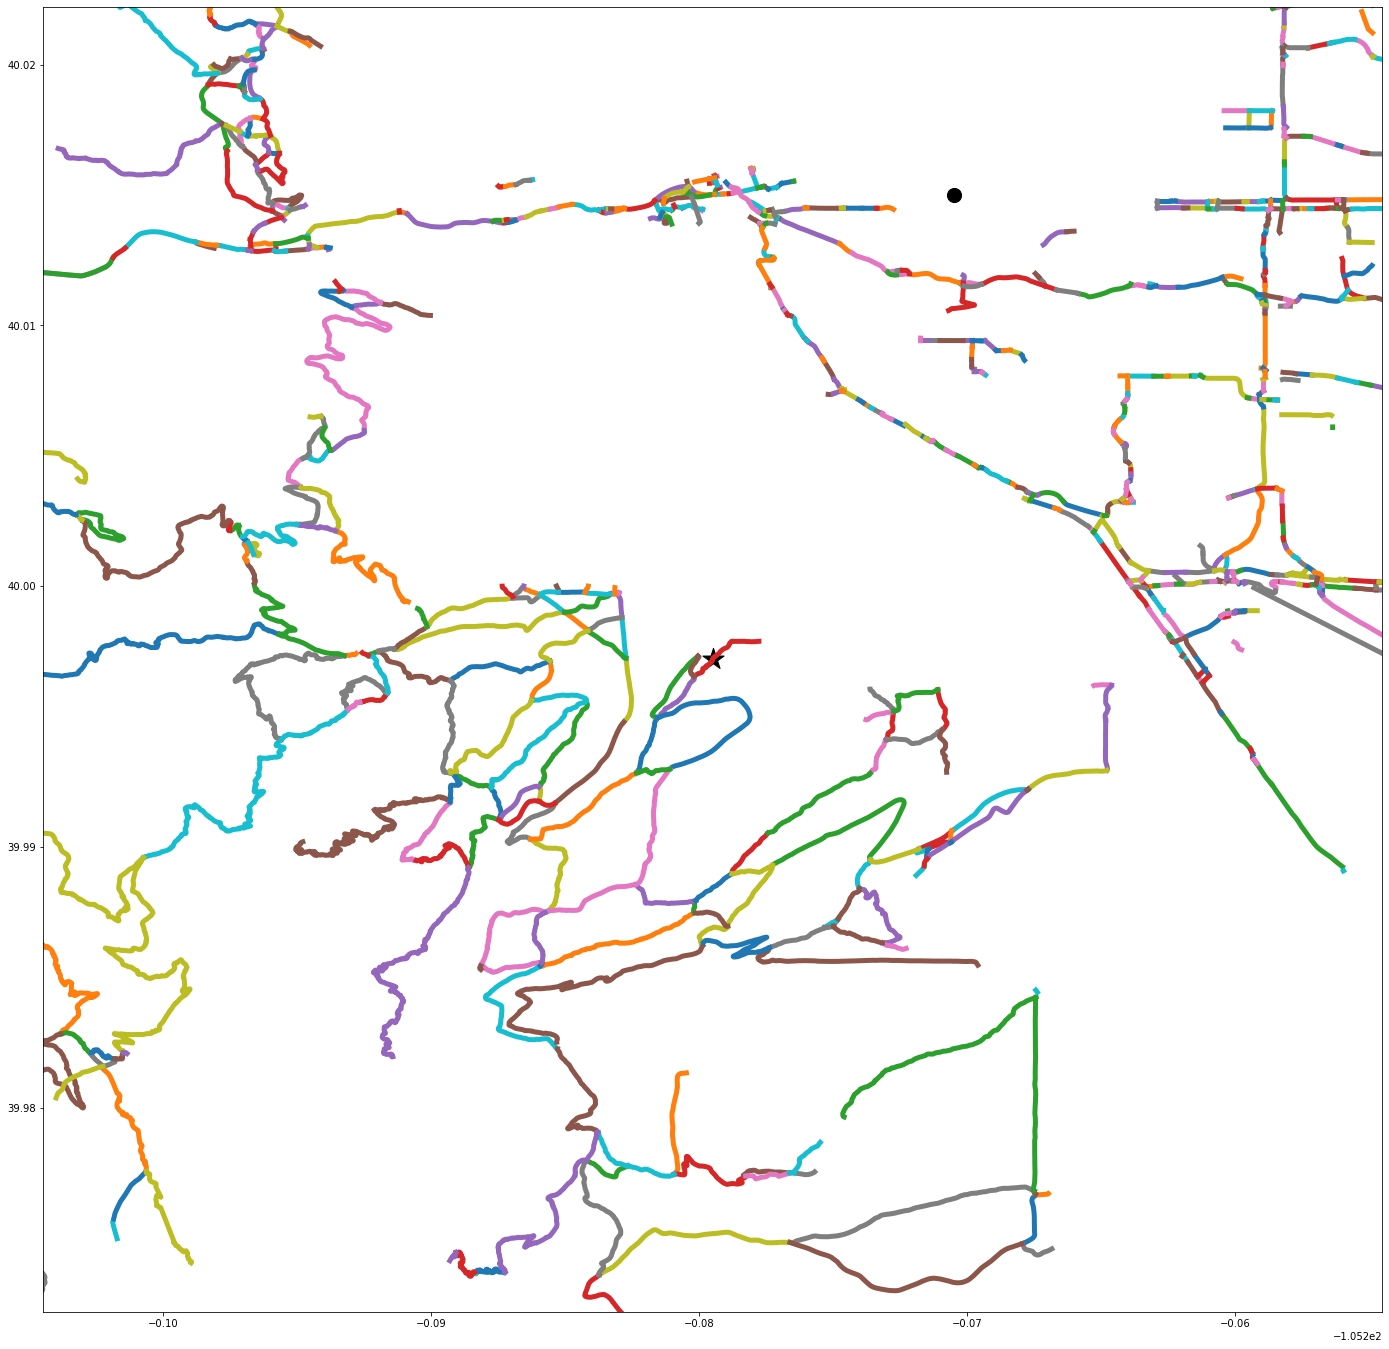

In [154]:
gpx_data = make_gpx_data(gdf)
fig = make_plot(gdf, gpx_data)

/home/aemerick/anaconda3/envs/planit/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


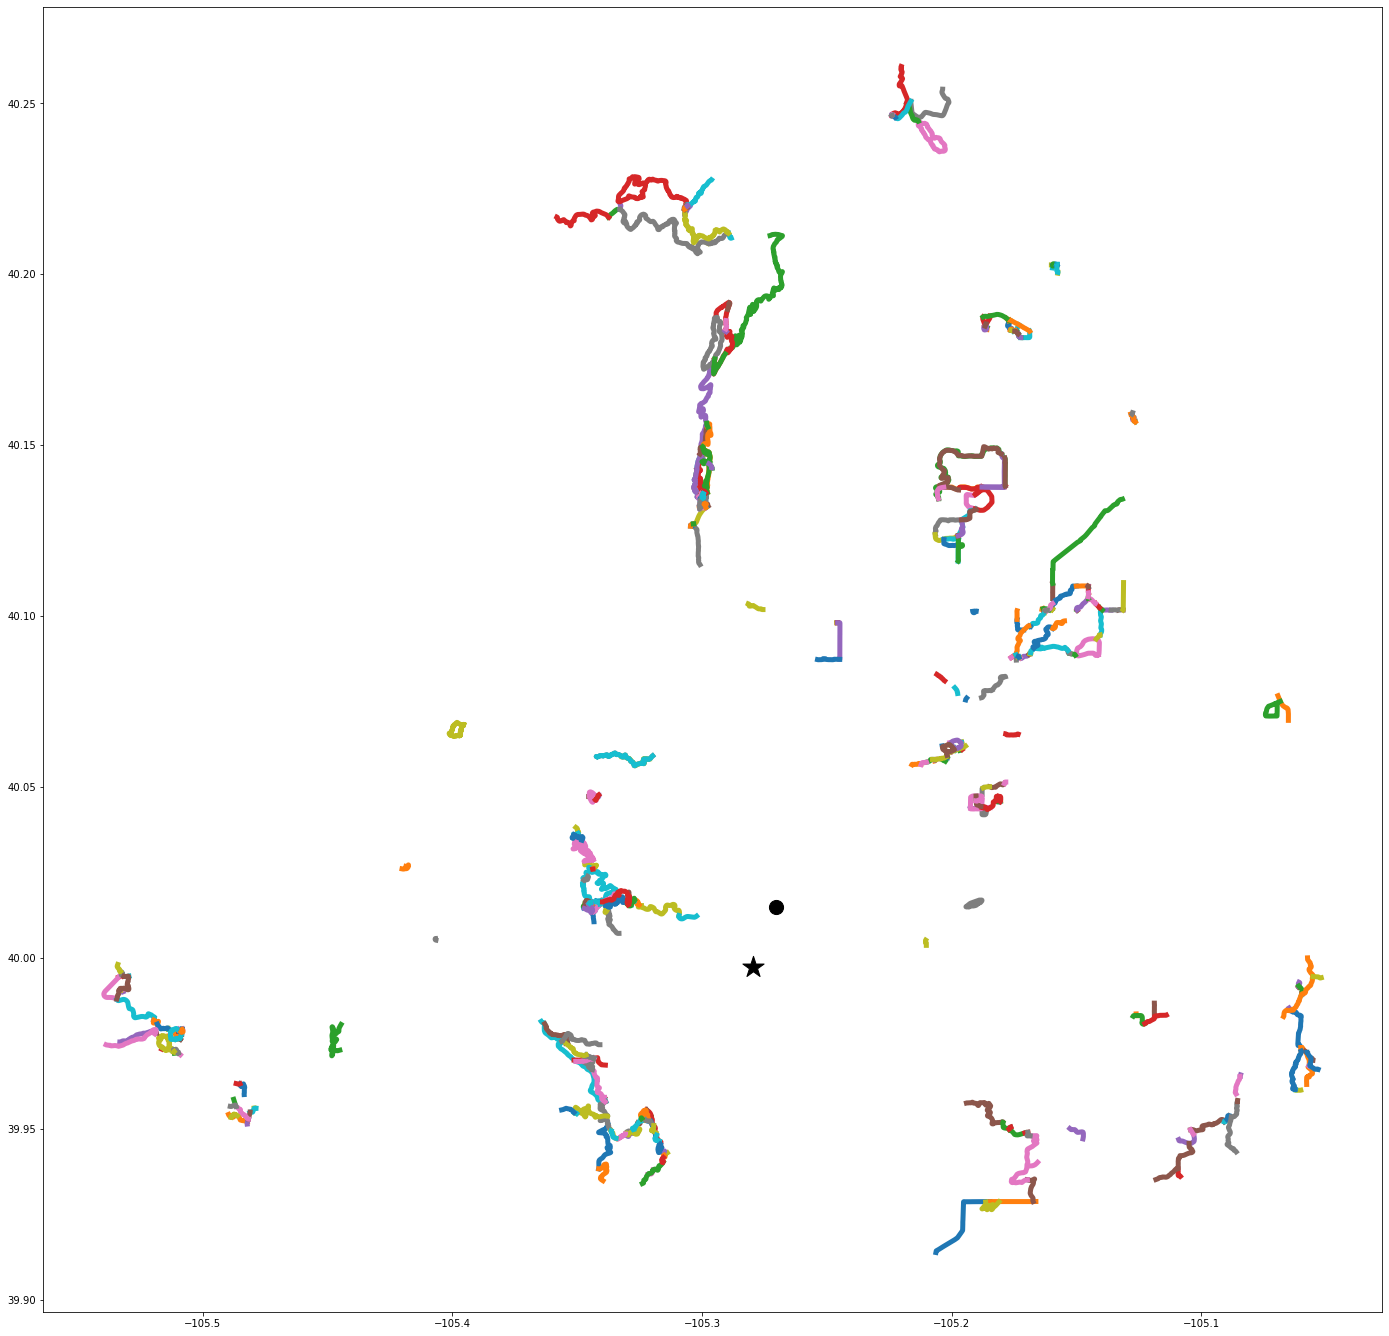

In [150]:
gpx_data_small = make_gpx_data(gdf_small)
fig = make_plot(gdf_small, gpx_data_small, zoom=False)

In [37]:
gdf.iloc[0]

OBJECTID                                                         1
TRAILNAME                                                AHC Trail
ALIAS                                                             
LENGTH                                                         0.5
PEDESTRIAN                                                     Yes
BIKE                                                            No
HORSE                                                           No
OHV                                                             No
TRAILTYPE                                                    Trail
SURTYPE                                                SoftSurface
STEWARD          https://www.bouldercounty.org/open-space/educa...
DATAOWNER                      Boulder County Parks and Open Space
COMMENTS                                                 dissolved
SHAPESTLength                                              849.297
DOGS                                                          

In [385]:
#%matplotlib widget
import contextily as ctx
gdf_crs = gdf.copy().to_crs(epsg=3857)
ax = gdf_crs.plot()
ax.figure.set_size_inches(16,16)
ctx.add_basemap(ax)
ax.figure.show()

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

# Lets try a data cleaning algorithm

In [324]:
import shapely 
import copy

def traverse_merge_list(ni, merge_list, to_merge):
    """
    Recursive function traverse a list (`merge_list`) containing
    lists of indexes within the same list to ensure that ALL
    grouping is properly done. `ni` is the index of `merge_list`
    that we are checking now.
    
    E.g. if `ni = 2`, `to_merge` should be initialized to
    `to_merge = [2]` and if `merge_list` is:
    
    x = [[],[],[4,3],[2],[2,6],[],[4]]
    
    All of these nodes are interconnected, so this function will
    set `to_merge` to be:
    
    to_merge = [2,4,3,6]
    
    and then sort it, finalizing to [2,3,4,6]
    
    """
   
    for nj in merge_list[ni]:
        if not (nj in to_merge):
            to_merge.append(nj)
            traverse_merge_list(nj, merge_list, to_merge)
        else:
            continue
    
    to_merge = np.sort(to_merge)
    
    return 

def process_data(input_gdf, threshold_distance = 1.0):
    """
    Given a gdf, process it! 
    
    This is the VERY brute force way of doing this because
    
    1) I only have to ultimately do it once for the MVP of this project
    
    and
    
    2) the smart part of my brain is semi-fried and I'm just 
    trying to get code down....
    which means
    
    3) way too many loops
    
    threshold_distance  :  distance between two nodes to merge (in m!)
    """
    _gdf = input_gdf.copy()
    
    
    small_dataset_type = False # assume we're on a larger dataset
    if 'OBJECTID' in _gdf.columns:
        small_dataset_type = True # for small dataset columns
    
    #
    # step one, break apart all multi-line segments into their own
    # rows. Append to the end and delete original.
    #
    numrows = len(_gdf)
    
    to_drop   = []
    to_append = []
    for i, row in _gdf.iterrows():
        if isinstance(row['geometry'], shapely.geometry.multilinestring.MultiLineString):
            
            for iseg, seg in enumerate(row['geometry']):
                dcopy               = copy.deepcopy(row)
                dcopy['geometry']   = seg
                
                # make sure unique ID and still refers back to original:
                if small_dataset_type: 
                    dcopy['OBJECTID']   = row['OBJECTID'] + (0.1*iseg)
                else: 
                    dcopy['GlobalID']   = row['GlobalID'] + '%i'%(iseg)
                    dcopy['BATTrailID'] = row['BATTrailID'] + '-%i'%(iseg)
                    
                to_append.append(dcopy)
            
            # remove multiline instance 
            to_drop.append(i)
            
    #print(to_drop, len(to_drop))
    _gdf = _gdf.drop(to_drop)
    _gdf = _gdf.append(to_append, ignore_index=True)
    
    #
    # Step 2: Get list of all nodes as all segment end points
    #
    
    # list of dictionaries containing node properties
    # this will need to be converted to list of [ (index, {}) ]
    numrows   = len(_gdf)    
    nodes = [{'index':0 , 'lat':0,'long':0,'edges':[]} for _ in range(2*numrows)] # initially 2x number of edges
    edges = [() for _ in range(numrows)] # list of tail and head nodes (one for each row)
    
    ni = 0 # node index 
    for i, row in _gdf.iterrows():
        # print(ni, i, row['geometry'].coords[0])
        coords = row['geometry'].coords
        
        nodes[ni]['long'], nodes[ni]['lat']     = coords[0][0],  coords[0][1]
        nodes[ni+1]['long'], nodes[ni+1]['lat'] = coords[-1][0], coords[-1][1]
        
        # edge indexes this node connects to - trivial for now
        nodes[ni]['edges']   = [i] 
        nodes[ni+1]['edges'] = [i] 
        
        nodes[ni]['index']   = ni
        nodes[ni+1]['index'] = ni+1 # saving this (trivial) to do merging properly
        
        edges[i] = (ni,ni+1)       # tail and head nodes for each edge
        
        ni += 2
        
    print("Computed %i nodes for %i edges"%(len(nodes),len(edges)))
    
    #
    #
    # Step 3: Brute force to find distances between nodes.
    #         If nodes are < some value separated then JOIN
    #
    #
    
    lat  = [n['lat'] for n in nodes]
    long = [n['long'] for n in nodes]
    elev = [elevation_data.get_elevation(x,y) for (x,y) in zip(lat,long)]
    
    numnodes    = len(nodes)
    merge_list  = [[] for _ in range(numnodes)] # for each node, list of nodes merging with
    #numnodes = 100
    
    for ni in range(numnodes):
        edgei = ni // 2
        
        for nj in range(ni+1, numnodes):
            d = gpxpy.geo.distance(lat[ni], long[ni], elev[ni],
                                   lat[nj], long[nj], elev[nj])
            
            
            # if d is within threshold AND
            # the nodes are not at the end of the same segment
            if d < threshold_distance and ( (ni,nj) != edges[edgei] ):
                merge_list[ni].append(nj)
                merge_list[nj].append(ni) # add to a merge list 
                
    #            
    # now we need to MERGE together all of the nodes
    # and re-assign the edges for them
    #
    to_append = []
    to_drop   = []
    
    mask = np.zeros(len(merge_list), dtype=bool)
    edge_relabel = {i:i for i in range(numnodes)} # use to relabel nodes in edges list later
    
    for ni in range(numnodes):
        
        if (len(merge_list[ni]) == 0) or mask[ni]: # empty or already completed
            continue
            
        # now we have one!!!
        # we merge by
        #
        #  1)  making new dict that has average lat, long of
        #      nodes to merge
        #
        #  2) re-labelling edges that touch these nodes with the
        #     new node index (take to be the min of nodes being merged)
        

        # gathers list of nodes that are linked together in common
        # with the current node and all nodes that may be chained 
        # off of a linked node that is not directly linked with this one
        # to group ALL of them together.
        #
        # nodes to merge are in `to_merge`
        to_merge = [ni]        
        traverse_merge_list(ni, merge_list, to_merge)
        
        mask[to_merge] = True # flag these to not repeat merge again

        nodes_select = [nodes[nj] for nj in to_merge]
        
        new_node  = {'index' : np.min(to_merge),
                     'lat'   : np.average([x['lat'] for x in nodes_select]),
                     'long'  : np.average([x['long'] for x in nodes_select]),
                     'edges' : [x['edges'] for x in nodes_select] }
        
        # need to relabel edges !!
        for nj in to_merge:
            edge_relabel[nj] = new_node['index']
            
            nodes[nj]['index'] = -999 # flag for deletion
        
        # add to append list
        to_append.append(new_node)
        # add to drop list
        to_drop.extend(to_merge)
    
    # print('append: ', to_append)
    print("Modifying Nodes. Creating %i new nodes from merging %i together"%(len(to_append),len(to_drop)))
    
    nodes.extend(to_append)

    nodes = [n for n in nodes if n['index'] >= 0]
    
    print("New node list length (%i) from previous (%i)"%(len(nodes),numnodes))
        
    # might be nice to do one more step to make node indexes 
    # continuous. skip for now.
    
    # assign new tail head nodes to all edges... and done!!
    for i in range(len(edges)):
        edges[i] = (edge_relabel[edges[i][0]], edge_relabel[edges[i][1]])


    # lets try and make the graph
    G = nx.Graph()
    
    # list of tuples [(index, {})....]
    G.add_nodes_from( [(n['index'], {k : n[k] for k in ['lat','long','edges']}) for n in nodes])
                     
    # edges
    G.add_edges_from( [ (e[0],e[1], _gdf.iloc[i]) for i,e in enumerate(edges)])
        
    # Last step
    # Recompute all distances, elevation gains, elevation losses
    # min grade, max grade, average grade for consistency
    #           
    return _gdf, G # nodes, edges #, lat, long, merge_list
        
        

In [325]:
x = {'one':1, 'two':2, 'three':3}



In [354]:
new_df, G = process_data(gdf)

Computed 22200 nodes for 11100 edges
Modifying Nodes. Creating 7101 new nodes from merging 17255 together
New node list length (12046) from previous (22200)


In [383]:
def plot(graph, node_order=None,
         weight='distance',
         region = None):
    
    #pos = nx.spring_layout(graph, weight=weight, seed = 12345)
    
    
    pos = {ni : np.array([n['long'],n['lat']]) for ni,n in graph.nodes(data=True)}
    
    pc = nx.draw_networkx_nodes(graph, pos, node_size=200)
    ax = pc.figure.axes[0]

    pc.figure.set_size_inches(20,20)

    #edges = [(u,v)]
    #etraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] > 0]
    #enottraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] == 0]

    colors = 'black'
    #if not (node_order is None):
    #    ecolor_int = [node_order.index(e[0]) for e in etraveled]
    #    colors = magma((np.array(ecolor_int)+5) / ((1.0*len(node_order)+5)))
        
    temp = nx.draw_networkx_edges(graph, pos, edgelist=graph.edges, width=10, edge_color=colors)
    #temp = nx.draw_networkx_edges(graph, pos, edgelist=enottraveled, width=2, style='dashed')
    
    #try:
    #    edge_labels = { (u,v) : "%i"%(d['ShapeLen']) for (u,v,d) in graph.edges(data=True)}
    #except:    
    #    edge_labels = { (u,v) : "%i"%(d['SHAPESTLength']) for (u,v,d) in graph.edges(data=True)}
    #temp = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.5)
    
    #temp = nx.draw_networkx_labels(graph, pos, labels={n:n for n in graph.nodes()}, font_size=17,
    #                        font_color = 'black')
    chataqua = (-105.2795, 39.9972)
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 1000)


    #sep = 0.025
    #if zoom:
    #    ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
    #    ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
        
    #print(pos)
    return pc,ax

/home/aemerick/anaconda3/envs/planit/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


(-105.3045, -105.2545)

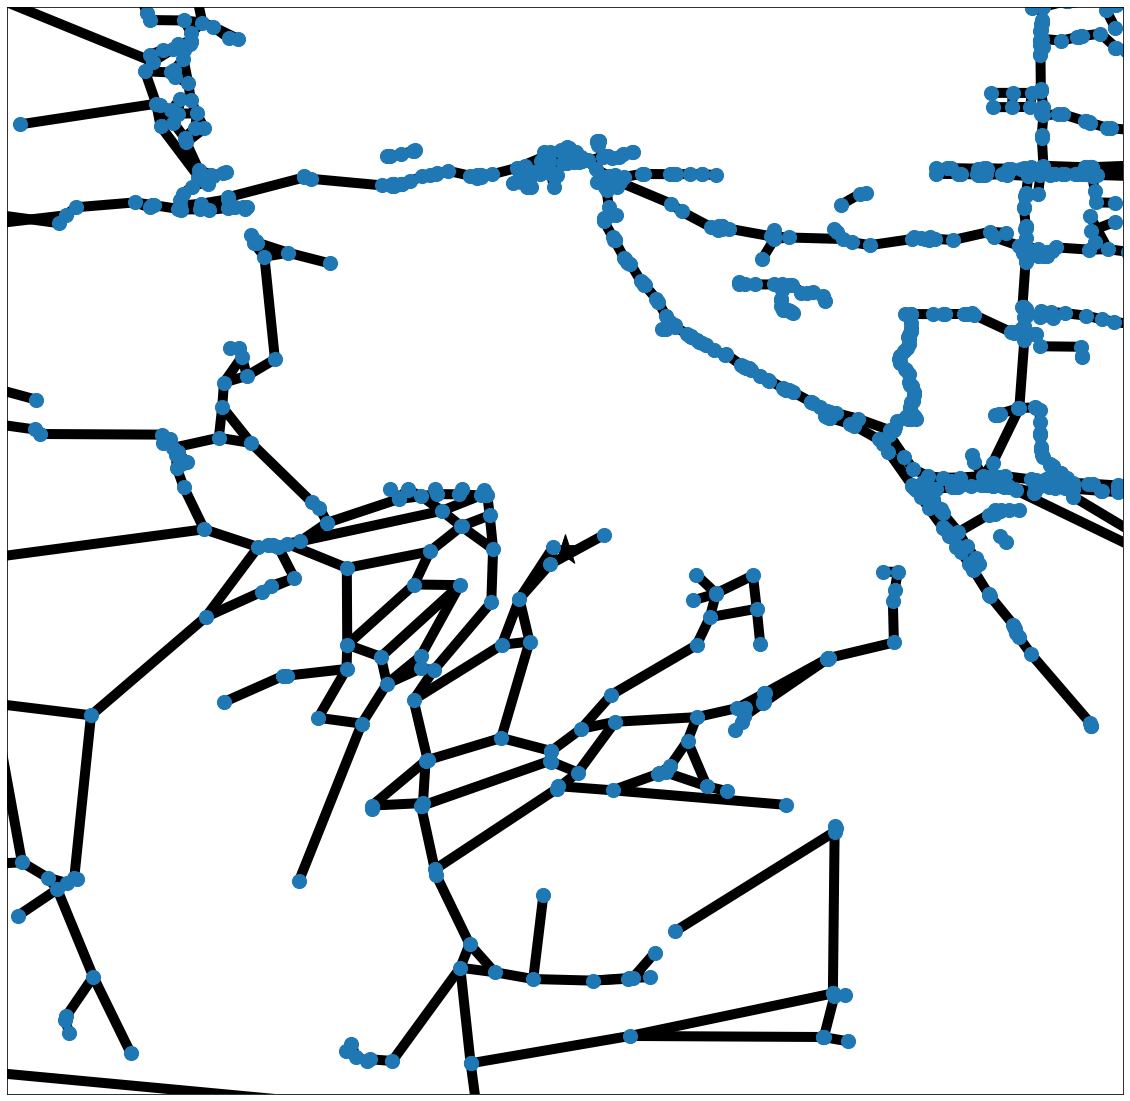

In [384]:
pc,ax = plot(G)
#ax.set_xlim()
pc.figure.show()


chataqua = (-105.2795, 39.9972)
sep = 0.025
ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)

<bound method _AxesBase.set_xlim of <AxesSubplot:>>

In [179]:
# find the maximum distances in each segment
new_df = gdf # process_data(gdf)

all_max = np.zeros(len(new_df))
all_min = np.zeros(len(new_df))

gpx_data = make_gpx_data(new_df)

for i in np.arange(len(new_df)):
    if gpx_data[i] is None or isinstance(gpx_data[i],list):
        all_max[i] = -1
        all_min[i] = -1
    else:
        
        all_max[i] = np.max(get_distances(gpx_data[i].points))
        all_min[i] = np.min(get_distances(gpx_data[i].points))

print("Smallest and largest min along all segments: ")        
print(np.min(all_min[all_min>0]), np.max(all_min))       

print("Smallest and largest max along all segments: ")        
print(np.min(all_max[all_max>0]), np.max(all_max))

Smallest and largest min along all segments: 
0.0008421864400837408 1414.0515862759555
Smallest and largest max along all segments: 
0.0029182205911486335 6857.4198166665365
